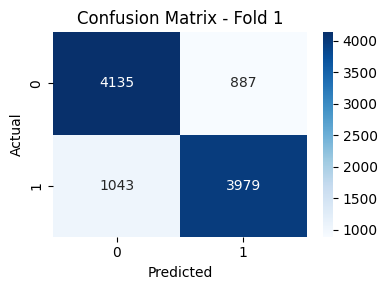

Fold 1:
   Accuracy     : 0.8078
   Precision    : 0.8177
   Recall       : 0.7923
   F1-score     : 0.8048
   ROC AUC      : 0.8919
   Avg Confidence: 0.8060



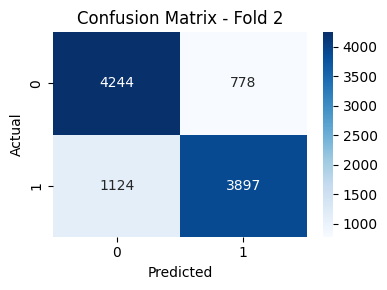

Fold 2:
   Accuracy     : 0.8106
   Precision    : 0.8336
   Recall       : 0.7761
   F1-score     : 0.8038
   ROC AUC      : 0.8895
   Avg Confidence: 0.8069



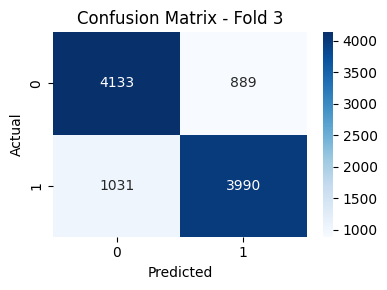

Fold 3:
   Accuracy     : 0.8088
   Precision    : 0.8178
   Recall       : 0.7947
   F1-score     : 0.8061
   ROC AUC      : 0.8900
   Avg Confidence: 0.8070



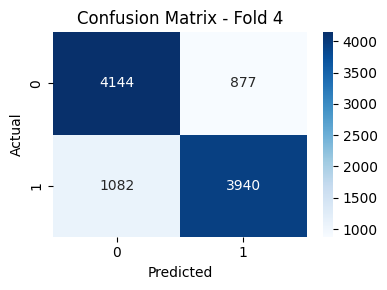

Fold 4:
   Accuracy     : 0.8049
   Precision    : 0.8179
   Recall       : 0.7845
   F1-score     : 0.8009
   ROC AUC      : 0.8858
   Avg Confidence: 0.8092



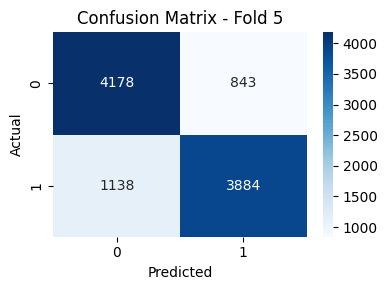

Fold 5:
   Accuracy     : 0.8027
   Precision    : 0.8217
   Recall       : 0.7734
   F1-score     : 0.7968
   ROC AUC      : 0.8872
   Avg Confidence: 0.8132

 Overall Metrics (averaged across 5 folds):
Fold             3.0000
Accuracy         0.8070
Precision        0.8217
Recall           0.7842
F1-score         0.8025
ROC AUC          0.8889
Avg Confidence   0.8085
 Classification Report - Fold 5:
              precision  recall  f1-score    support
No                0.786   0.832     0.808   5021.000
Yes               0.822   0.773     0.797   5022.000
accuracy          0.803   0.803     0.803      0.803
macro avg         0.804   0.803     0.803  10043.000
weighted avg      0.804   0.803     0.803  10043.000

 95% CI for Accuracy: (0.7950, 0.8105)



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix
)
from sklearn.metrics import classification_report
import scipy.stats as st

# Load data
df = pd.read_csv('/content/drive/MyDrive/datasets/heart_2022_with_nans.csv')

# Remove duplicates and drop rows with null in target
df = df.drop_duplicates()
df = df.dropna(subset=['HadHeartAttack'])

# Undersample majority class
majority_df = df[df['HadHeartAttack'] == 'No'].copy()
minority_df = df[df['HadHeartAttack'] == 'Yes'].copy()
majority_df['MissingCount'] = majority_df.isnull().sum(axis=1)
majority_df_sorted = majority_df.sort_values(by='MissingCount', ascending=False)
target_count = len(minority_df)
majority_df_cleaned = majority_df_sorted.tail(target_count).drop(columns=['MissingCount'])
df = pd.concat([minority_df, majority_df_cleaned], axis=0).sample(frac=1, random_state=42)

# Drop irrelevant columns
cols_to_remove = [
    'State', 'LastCheckupTime', 'RemovedTeeth', 'HadSkinCancer', 'HadArthritis',
    'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating',
    'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'ChestScan',
    'RaceEthnicityCategory', 'HeightInMeters', 'WeightInKilograms', 'HIVTesting',
    'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'
]
df.drop(columns=cols_to_remove, inplace=True, errors='ignore')

# Define feature columns
numerical_cols = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'BMI']
ordinal_cols = ['GeneralHealth', 'AgeCategory']
binary_cols = [
    'PhysicalActivities', 'HadAngina', 'HadStroke', 'HadAsthma',
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'AlcoholDrinkers'
]
ohe_cols = ['Sex', 'HadDiabetes', 'SmokerStatus', 'ECigaretteUsage']

# Mapping functions
general_health_map = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Very good': 3, 'Excellent': 4}
age_order = [
    'Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34', 'Age 35 to 39',
    'Age 40 to 44', 'Age 45 to 49', 'Age 50 to 54', 'Age 55 to 59',
    'Age 60 to 64', 'Age 65 to 69', 'Age 70 to 74', 'Age 75 to 79', 'Age 80 or older'
]
age_map = {age: idx for idx, age in enumerate(age_order)}
binary_map = {'No': 0, 'Yes': 1}

def map_ordinal(X):
    X = X.copy()
    X['GeneralHealth'] = X['GeneralHealth'].map(general_health_map)
    X['AgeCategory'] = X['AgeCategory'].map(age_map)
    return X

def map_binary(X):
    X = X.copy()
    for col in binary_cols:
        X[col] = X[col].map(binary_map)
    return X

# Target encoding
le = LabelEncoder()
y = le.fit_transform(df['HadHeartAttack'])
X = df.drop(columns=['HadHeartAttack'])

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_raw, X_test_raw = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # Apply ordinal and binary mappings
    X_train_raw = map_ordinal(X_train_raw)
    X_train_raw = map_binary(X_train_raw)
    X_test_raw = map_ordinal(X_test_raw)
    X_test_raw = map_binary(X_test_raw)

    # Remove outliers from training set
    Q1 = X_train_raw[numerical_cols].quantile(0.25)
    Q3 = X_train_raw[numerical_cols].quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = ~((X_train_raw[numerical_cols] < (Q1 - 1.5 * IQR)) |
                     (X_train_raw[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
    X_train_raw = X_train_raw[outlier_mask]
    y_train = y_train[outlier_mask]

    # Preprocessing
    preprocessor = ColumnTransformer(transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_cols),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_cols),
        ('passthrough', 'passthrough', ordinal_cols + binary_cols)
    ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced'))
    ])

    pipeline.fit(X_train_raw, y_train)
    y_pred = pipeline.predict(X_test_raw)
    y_proba = pipeline.predict_proba(X_test_raw)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    conf = confusion_matrix(y_test, y_pred)
    avg_conf = np.mean(np.max(pipeline.predict_proba(X_test_raw), axis=1))

    fold_metrics.append({
        'Fold': fold,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC AUC': auc,
        'Avg Confidence': avg_conf
    })

    plt.figure(figsize=(4, 3))
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    print(f"Fold {fold}:")
    print(f"   Accuracy     : {acc:.4f}")
    print(f"   Precision    : {prec:.4f}")
    print(f"   Recall       : {rec:.4f}")
    print(f"   F1-score     : {f1:.4f}")
    print(f"   ROC AUC      : {auc:.4f}")
    print(f"   Avg Confidence: {avg_conf:.4f}\n")

metrics_df = pd.DataFrame(fold_metrics)
print(" Overall Metrics (averaged across 5 folds):")
print(metrics_df.mean(numeric_only=True).to_string(float_format="%.4f"))
# Classification report
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(f" Classification Report - Fold {fold}:\n{report_df.round(3)}\n")

# Confidence interval for accuracy
n = len(y_test)
se = np.sqrt((acc * (1 - acc)) / n)
ci_low, ci_high = st.norm.interval(0.95, loc=acc, scale=se)
print(f" 95% CI for Accuracy: ({ci_low:.4f}, {ci_high:.4f})\n")